In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [ ]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

## Global Variables

In [ ]:
checkpoint = "/home/mpyg/Documents/Codes/MIP_SAM/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

## Codes

In [ ]:

sam = sam_model_registry[model_type](checkpoint=checkpoint)
onnx_model_path = None

#### Export an ONNX Model

In [ ]:
if onnx_model_path is None:
    import warnings

    onnx_model_path = "/home/mpyg/Documents/Codes/MIP_SAM/model/sam_onnx_example.onnx"

    onnx_model = SamOnnxModel(sam, return_single_mask=True)

    dynamic_axes = {
        "point_coords": {1: "num_points"},
        "point_labels": {1: "num_points"},
    }

    embed_dim = sam.prompt_encoder.embed_dim
    embed_size = sam.prompt_encoder.image_embedding_size
    mask_input_size = [4 * x for x in embed_size]
    dummy_inputs = {
        "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
        "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
        "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
        "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
        "has_mask_input": torch.tensor([1], dtype=torch.float),
        "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
    }
    output_names = ["masks", "iou_predictions", "low_res_masks"]

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        with open(onnx_model_path, "wb") as f:
            torch.onnx.export(
                onnx_model,
                tuple(dummy_inputs.values()),
                f,
                export_params=True,
                verbose=False,
                opset_version=17,
                do_constant_folding=True,
                input_names=list(dummy_inputs.keys()),
                output_names=output_names,
                dynamic_axes=dynamic_axes,
            )

### Example Image

In [ ]:
image = cv2.imread('/home/mpyg/Documents/Codes/MIP_SAM/img/Eins.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Using an ONNX Model

In [ ]:
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

### SAM Encode

In [ ]:
sam.to(device='cuda')
predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)

In [ ]:
image_embedding = predictor.get_image_embedding().cpu().numpy()

In [ ]:
image_embedding.shape

### Example point input

In [ ]:
input_point = np.array([[image.shape[1] / 2, image.shape[0] / 2]])
input_label = np.array([1])

Add a batch index, concatenate a padding point, and transform.

In [ ]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

Create an empty mask input and an indicator for no mask.

In [ ]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

Package the inputs to run in the onnx model

In [ ]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

Predict a mask and threshold it.

In [ ]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [ ]:
masks.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Auto Mask Generation

In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [9]:
checkpoint = "/home/mpyg/Documents/Codes/MIP_SAM/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [10]:
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to('cuda')
print()

In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [12]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [13]:
image = cv2.imread('/home/mpyg/Documents/Codes/MIP_SAM/img/img_0_clip_0.jpg')

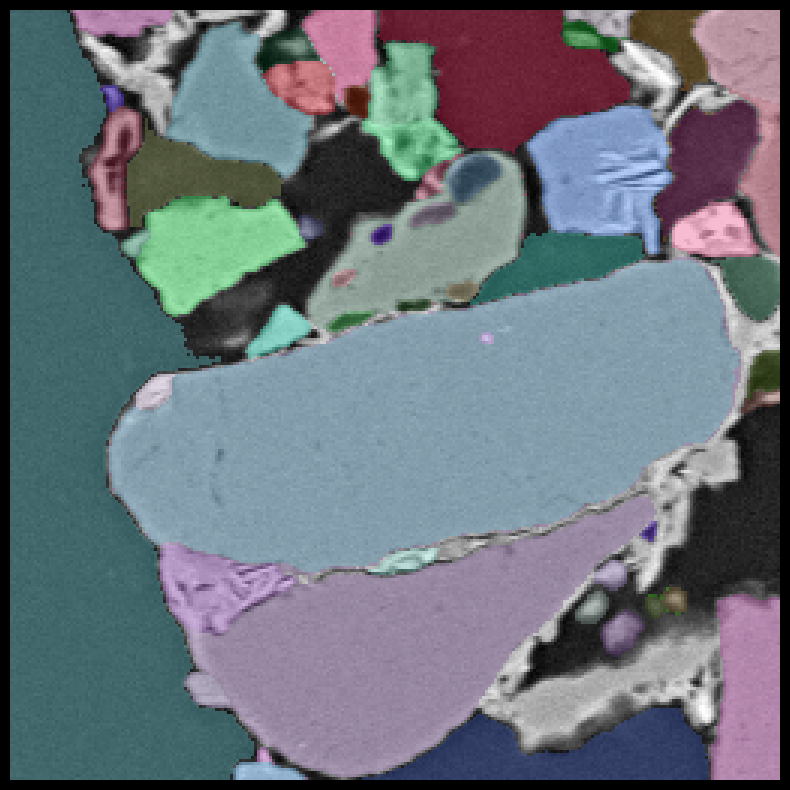

In [14]:
masks = mask_generator.generate(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 